# Traveling Salesman Problem
*The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$.* 

*This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time.*


# Useful References

[1] **Quadratic Unconstrained Binary Optimization Problem Preprocessing:
Theory and Empirical Analysis** [https://arxiv.org/ftp/arxiv/papers/1705/1705.09844.pdf](https://arxiv.org/ftp/arxiv/papers/1705/1705.09844.pdf)

[2] **Adiabatic Quantum Computing:** [https://arxiv.org/pdf/1611.04471.pdf](https://arxiv.org/pdf/1611.04471.pdf)

[3] **A Quantum Approximate Optimization Algorithm**: [https://arxiv.org/pdf/1411.4028.pdf](https://arxiv.org/pdf/1411.4028.pdf)

[4] **From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz** : [https://arxiv.org/pdf/1709.03489.pdf](https://arxiv.org/pdf/1709.03489.pdf)

[5] ****Ising formulations of many NP problems:**** [https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full)

[6] **Constraint preserving mixers for QAOA:** [https://arxiv.org/pdf/2203.06095.pdf](https://arxiv.org/pdf/2203.06095.pdf)

In [1]:
# installing necessary modules
# ! pip install networkx
# ! pip install qibo 

#already installed in anaconda


# Introductory Challenge  

*The initial task in this challenge requires you to determine a Hamiltonian that can effectively solve the Traveling Salesman Problem (TSP).*
*To achieve this, a set of functions has been provided for you to complete, enabling you to find the solution using both Quantum Alternating Operator Ansatz (QAOA) and Adiabatic Quantum Optimization (AQO).*

*To solve this challenge, you will need to accomplish the following tasks:*
1. *Construct the cost, mixer, and initial Symbolic Hamiltonians that will be used for QAOA and AQO.*
2. *Prepare a suitable initial state for the system.*
3. *Print and visualize your results.*
4. *Calculate the Fidelity of your results for both QAOA and AQO.*

## Graph construction

We first have to define the different camps and distances using a graph. Here you can find the definition of these camps:

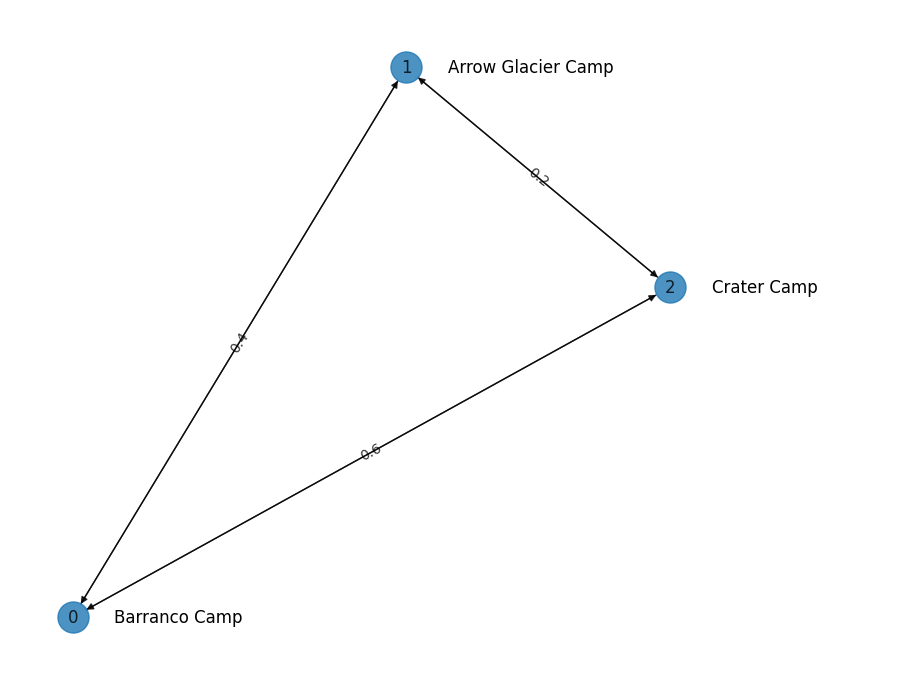

In [4]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.4)
G.add_edge(1, 0, weight=0.4)

G.add_edge(0, 2, weight=0.6)
G.add_edge(2, 0, weight=0.6)

G.add_edge(1, 2, weight=0.2)
G.add_edge(2, 1, weight=0.2)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

# creating node labels
labels = {}
labels[0] = 'Barranco Camp'
labels[1] = 'Arrow Glacier Camp'
labels[2] = 'Crater Camp'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

We start off with a 3 node graph without restrictions on sarting and ending nodes, and full connectivity between nodes. In this case, the fully connected graph has $N^2$ degrees of freedom, correspnding to the $N$ nodes being able to be in any of the $N$ positions in the cycle.
To find a cycle that visits each vertex exactly once, reducing at the same time the cost of the cycle, we will encode the position of each verteX in the cycle using $N^2$  qubits and defining $\ket{k}_{iN+j}$, $k = 0,1$ as the states in which the vertex i is (k = 1) or is not (k = 0) in position j in the cycle.
To construct the hamiltonian we will follow the formulation of the TSP given in [5]. The only difference from that formulation is that instead of working with the operator (1+Z)/2, which has eigenvalues 0 and 1 on the single-qubit states $\ket{1}$ and $\ket{0}$, respectively, we will work with the operator (1-Z)/2, so that the eigenvalues match with the label of the states. With this in mind, the total hamiltonian describing the problem to be solved consists of 4 different terms that can be split into the hamiltonian cycle problem itself (first 3 terms) and the tsp problem of minimizing the cycle's cost (last term). In our case, we will label them h_cycle and h_tsp, respectively.

$$

H = \sum_{v=1}^{N} \left(1 - \sum_{j=1}^{N} X_{v,j}\right)^2 + \sum_{j=1}^{N} \left(1 - \sum_{v=1}^{N} X_{v,j}\right)^2 + \sum_{(u,v) \notin E} \sum_{j=1}^{N} X_{u,j}X_{v,j+1} + \sum_{(u,v) \in E} W_{uv} \sum_{j=1}^N X_{u,j} X_{v,j+1}

$$

Where $X_{i,j} = 0.5(1-Z(iN+j))$ is the operator that when acting on $\ket{k}_{iN+j}$ takes the value 1 if the verteX $i$ is in position $j$ in the cycle ($k=1$) and 0 otherwise ($k = 0$), and $W_{uv}$ is the weight of the edge connecting vertices $u$ and $v$.

The first 3 terms encode following constraints:

- 1st term: Each node has to appear only one time in each hamiltonian cycle.
- 2nd term: Each position in a cycle has to be filled by just one node. 
- 3rd term: The cycle has to be connected --> if there is no edge between two nodes, they cannot be consecutive in the cycle.

And the last one encodes the cost function to be minimized:
- 4th term: The cost of the cycle is the sum of the weights of the edges that connect consecutive nodes in the cycle.

On the other hand, to perform the AQO the initial hamiltonian that we will use is $ H_i = \sum_{i = 1}^N -X(i) $ (as given in [5]) as its ground state is the uniform superposition of all the possible states of the system, therefore ensuring that the solution lies within the search space.


For the QAOA part of the first problem we will follow the mixer construction given in https://core.ac.uk/download/pdf/227725576.pdf:

$$

H_{mix} = \sum_{u<v}\prod_{j=1}^N (X_{u,j}X_{v,j}+Y_{u,j}Y_{v,j})

$$

The approach using ladder operators shown in [6] was also considered, but ended up being discarded as the constraints of the hamiltonian cycle were not being satisfied.


  

In [5]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians

def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''

#--------------------------------------------------------------------------------------------------

    h_cycle = 0

    for i in range(G.number_of_nodes()):
        h_cycle += (1-sum((1-Z(i*G.number_of_nodes()+j))/2 for j in range(G.number_of_nodes())))**2
        h_cycle += (1-sum((1-Z(i+j*G.number_of_nodes()))/2 for j in range(G.number_of_nodes())))**2
    
    node_pairs = [(i, j) for i in range(G.number_of_nodes()) for j in range(G.number_of_nodes())]
    no_edges = [i for i in list(G.edges()) if i not in node_pairs]

    for edge in no_edges:
        u = edge[0]*G.number_of_nodes()
        v = edge[1]*G.number_of_nodes()
        h_cycle += sum((1-Z(u+k))*(1-Z(v+k+1))/4 for k in range(G.number_of_nodes()-1))
        h_cycle += (1-Z(u+G.number_of_nodes()-1))*(1-Z(v))/4
            
#--------------------------------------------------------------------------------------------------

    h_tsp = 0

    for edge in G.edges(data = True):

        u = edge[0]*G.number_of_nodes()
        v = edge[1]*G.number_of_nodes()

        edge_weight = edge[2]['weight']

        for k in range(G.number_of_nodes()-1):
            
            h_tsp += edge_weight*(1-Z(u+k))*(1-Z(v+k+1))/4

        h_tsp += edge_weight*(1-Z(u+G.number_of_nodes()-1))*(1-Z(v))/4

#--------------------------------------------------------------------------------------------------

    return hamiltonians.SymbolicHamiltonian(h_tsp+h_cycle)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    h_mix = sum(-X(i) for i in range((G.number_of_nodes())**2))

    return hamiltonians.SymbolicHamiltonian(h_mix)

def prepare_initial_state(G: nx.Graph):
    '''
    prepare the initial state of the system.

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The initial state of the system.

    '''
    # The initial state of the system is the uniform superposition of all possible states
    # for a system of N^2 qubits, where N is the number of nodes of the graph.

    return np.ones(2**((G.number_of_nodes())**2))/(np.sqrt(2**((G.number_of_nodes())**2)))


def display_solution(graph: nx.Graph, state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''
    # We have encoded the solution of the TSP as a string where blocks of N bits represent the
    # position of the nodes in the solution. The first N bits represent the position of the first
    # node, the next N bits represent the position of the second node, and so on.

    print('The solution is:', state)

    nodes = np.sqrt(len(state)).astype(int)         
    order = np.zeros(nodes)

    for i in range(len(state)):

        if state[i] == '1':
            node = i//nodes # get the node number
            position = i%nodes+1  # get the position of the node 

            print('Node', node, 'is in position', position)

            order[position-1] = node
    
    # plot the solution
    sol_edges = [(order[i], order[i+1]) for i in range(len(order)-1)]
    G_sol = graph.copy()


    edges_2_drop = [i for i in list(G_sol.edges()) if i not in sol_edges]

    for edge in edges_2_drop:
        G_sol.remove_edge(edge[0], edge[1])

    
    edge_labels= {}
    for (u,v) in G_sol.edges():
        edge_labels[(u,v)] = G_sol[u][v]["weight"]

    pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

    # creating node labels
    labels = {}
    labels[0] = 'Barranco Camp'
    labels[1] = 'Arrow Glacier Camp'
    labels[2] = 'Crater Camp'

    # applying a shift to the node labels for readability purposes 
    shift = np.array([0.03, 0])
    shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

    # draw node labels
    nx.draw_networkx_labels(G_sol, shifted_pos, labels=labels, horizontalalignment="left")


    #plot the graph and the edge labels
    nx.draw_networkx_edge_labels(G_sol, pos, edge_labels=edge_labels, alpha=0.8)
    nx.draw(G_sol, pos, with_labels=True, alpha=0.8, node_size=500)

    # adjust frame to avoid cutting text, may need to adjust the value
    axis = plt.gca()
    lim = axis.get_xlim()
    axis.set_xlim([lim[0], lim[1] * 1.7])

    # increase the size of the figure
    figure_size = plt.gcf().get_size_inches()
    factor = 1.8
    plt.gcf().set_size_inches(factor * figure_size)

    plt.show()

    


    


# for the optional QAOA challenge:
def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:  
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    # I tried to build an XY-mixer following [6] and https://core.ac.uk/download/pdf/227725576.pdf
    # getting, most of the time, the right solution. However, every now and then, the solution
    # found is not the correct one found using AQO
    # I also tried to build a mixer using ladder operators (See the following function), following  the same references,
    # but got worse results

    
    #--------------------------------------------------------------------------------------------------
    h_mix = 0

    for j in range(G.number_of_nodes()):
        for i in range(j):
            
            k_sum = 1
            for k in range(G.number_of_nodes()):
                u = i*G.number_of_nodes()
                v = j*G.number_of_nodes()
                k_sum *= X(u+k)*X(v+k)+Y(u+k)*Y(v+k)
            
            h_mix += k_sum


def build_mixer_hamiltonian_2(G: nx.Graph) -> hamiltonians.SymbolicHamiltonian: #second mixer with bad results

    h_mix = 0

    for k in range(G.number_of_nodes()):
        for l in range(G.number_of_nodes()):
            for i in range(G.number_of_nodes()):
                for j in range(G.number_of_nodes()):
                    if i != j and k != l:
                        u = k*G.number_of_nodes()
                        v = l*G.number_of_nodes()
                        h_mix += s_minus(u+i)*s_minus(v+j)*s_plus(u+j)*s_plus(v+i)
    
    return hamiltonians.SymbolicHamiltonian(h_mix)

# we define the ladder operators to built the mixer
    
def s_plus(k: int):
    s_plus = X(k)+1j*Y(k)
    return s_plus

def s_minus(k: int):
    s_minus = X(k)-1j*Y(k)
    return s_minus





## Adiabatic Quantum Optimization

In [6]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.3
nqubits = (G.number_of_nodes()) ** 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t



# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|INFO|2023-07-12 23:37:26]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.13|WARNING|2023-07-12 23:37:26]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-07-12 23:37:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


The solution is: 001010100
Node 0 is in position 3
Node 1 is in position 2
Node 2 is in position 1


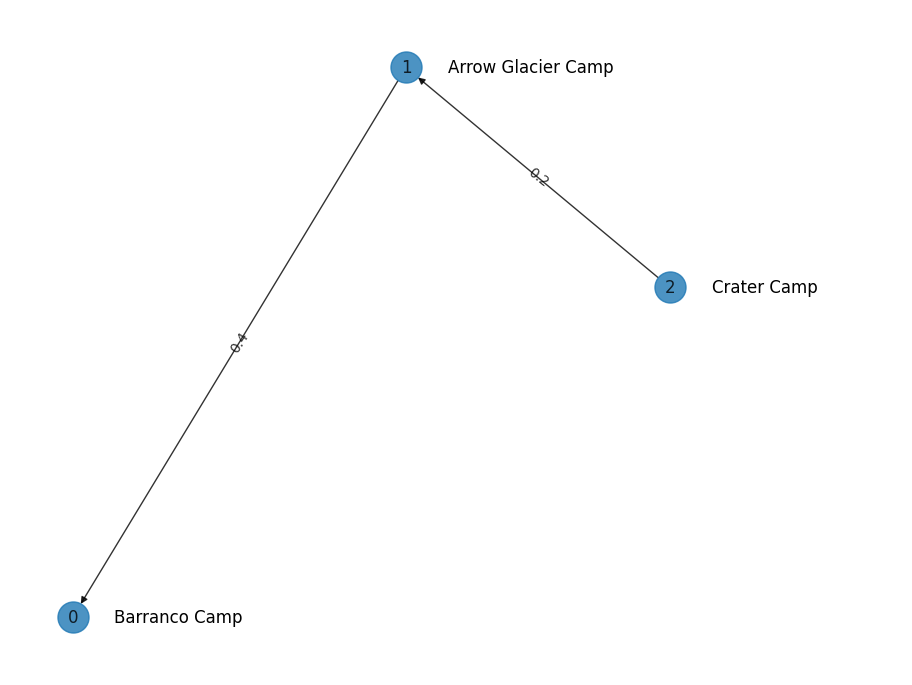

In [7]:
# execute the adiabatic optimization

T = 100
adiabatic_quantum_state = adiabatic_model.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(graph = G, state = adiabatic_solution) # adiabatic solution is a binary string containing the solution

We find a path that just by looking at the three node graph we can see that it is the optimal hamiltonian cycle. We can therefore conclude that the AQO algorithm performed as intended.

## Quantum Alternating Operator Ansatz (QAOA) [Optional]


As mentioned in the definition of the functions, different mixers have been tested. Here we show the results for both the XY mixer and the ladder operator mixer. The XY mixer was the one that gave the best results, as the ladder operator mixer did not satisfy the constraints of the hamiltonian cycle.

In [8]:
# XY-mixer solution
import numpy as np
from qibo import models, hamiltonians


nqubits = G.number_of_nodes() ** 2
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 6 
# I tried with 8 but the number of times I got the right solution was lower than with 6
# With 4 and 10 the restrictions on the nodes appearing just one time in a cycle was not satisfied

initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

number of qubits needed to solve the problem:  9
best energy:  2.2385245628521817


The solution is: 001010100
Node 0 is in position 3
Node 1 is in position 2
Node 2 is in position 1


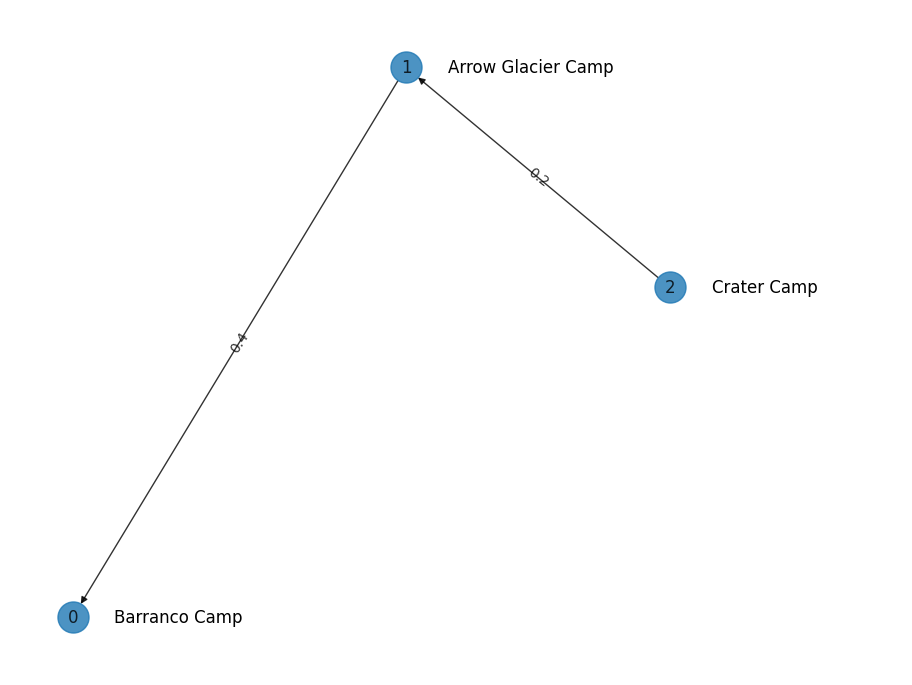

In [11]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 20000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(graph = G, state = qaoa_solution) # QAOA solution is a binary string containing the solution 

In [12]:
# Ladder-mixer solution

nqubits = G.number_of_nodes() ** 2
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian_2(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 6 
# I tried with 8 but the number of times I got the right solution was lower than with 6
# With 4 and 10 the restrictions on the nodes appearing just one time in a cycle was not satisfied

initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

number of qubits needed to solve the problem:  9
best energy:  7.770005456562427


The solution is: 011110001
Node 0 is in position 2
Node 0 is in position 3
Node 1 is in position 1
Node 1 is in position 2
Node 2 is in position 3


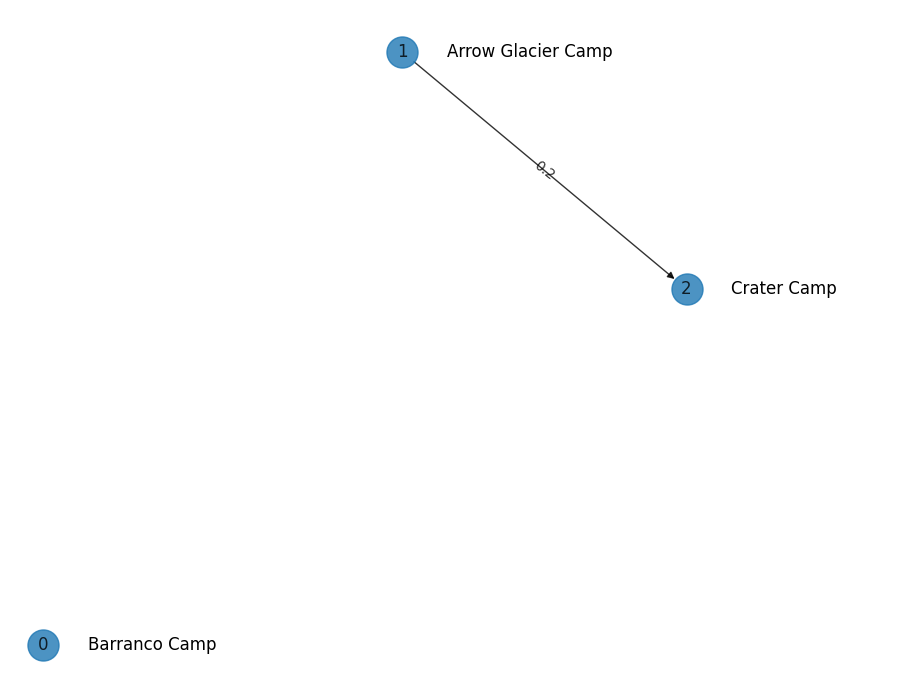

In [13]:
# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 20000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(graph = G, state = qaoa_solution) # QAOA solution is a binary string containing the solution 

We can see that the XY mixer, while not giving always the correct solution, does seem to always give a solution that satisfies the constraints of the hamiltonian cycle. This is not the case for the ladder operator mixer.

On the ohter hand, while the presented result for the XY mixer is the correct one, by running multiple times the circuit with the optimal parameters we can see that quite often the solution found is not correct, and while the algorithm is an approximate one, this does seem to be a bit too much of a deviation. This is probably due to the fact that the mixer hamiltonian is not the best one for the problem or even that the implementation is straight up wrong. 

# Real Life Challenges [Optional] 

*Extra points if you can solve this!*

*In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.*

*To solve this challenge, you will need to accomplish the following tasks:*

1. *Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.*
2. *Calculate and analyze the fidelity of both the AQO and QAOA solutions.*
3. *Experiment with different scheduling strategies to improve the fidelity of your solution.*

*It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!*

## Graph construction 

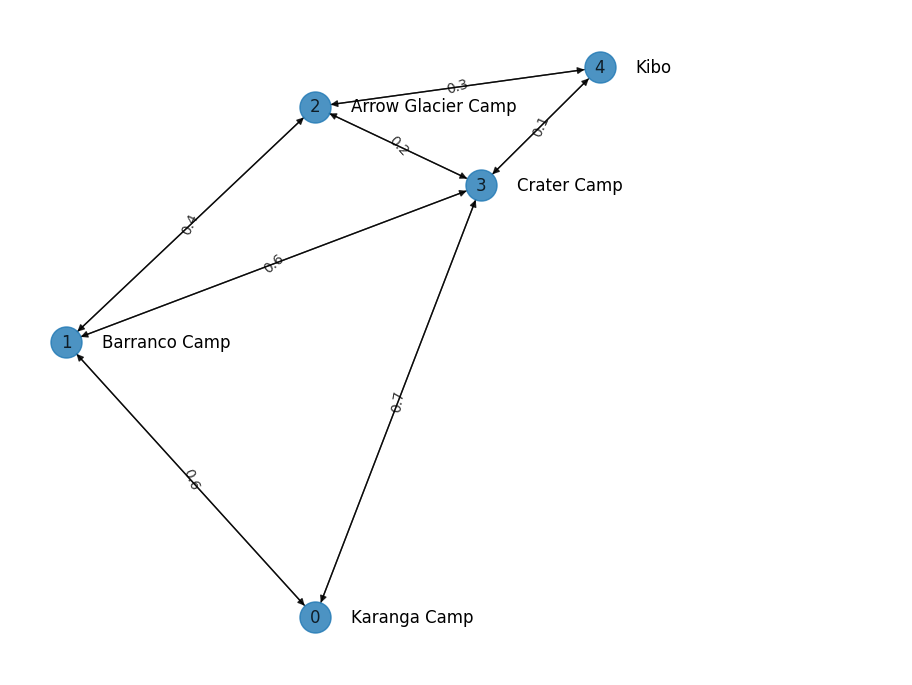

In [24]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G2 = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G2.add_edge(0, 1, weight=0.6)
G2.add_edge(1, 0, weight=0.6)

G2.add_edge(0, 3, weight=0.7)
G2.add_edge(3, 0, weight=0.7)

G2.add_edge(1, 3, weight=0.6)
G2.add_edge(3, 1, weight=0.6)

G2.add_edge(1, 2, weight=0.4)
G2.add_edge(2, 1, weight=0.4)

G2.add_edge(2, 3, weight=0.2)
G2.add_edge(3, 2, weight=0.2)

G2.add_edge(3, 4, weight=0.1)
G2.add_edge(4, 3, weight=0.1)

G2.add_edge(2, 4, weight=0.3)
G2.add_edge(4, 2, weight=0.3)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G2.edges():
    edge_labels[(u,v)] = G2[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# creating node labels
labels = {}
labels[0] = 'Karanga Camp'
labels[1] = 'Barranco Camp'
labels[2] = 'Arrow Glacier Camp'
labels[3] = 'Crater Camp'
labels[4] = 'Kibo'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G2, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G2, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

In the first part of the problem we were looking at a 3-node fully connected graph were the starting and ending nodes were not fixed. This meant that we had 9 degrees of freedom and therefore, that the solution had to be encoded using 9 qubits. In this case though, where we want to go from the bottom camp  to the top camp, not only has the starting and ending points fixed, but we also have the following constraints that reduce the number of degrees of freedom from the starting 9 :
- Only 2 out of the three middle nodes are connected to the starting node. 
- Only 2 out of the three middle nodes are connected to the ending node.
- To be able to cover all the 3 middle nodes, from node 3 one can only move to node 1. If node 3 is the second node in the cycle, then, it can only be followed by node 1. 
With all of this in mind, and using the same convention as in the previous part, we have only the following degrees of freedom:
- $x_{1,2}$  $x_{1,3}$
- $x_{2,3}$  $x_{2,4}$
- $x_{3,2}$  $x_{3,3}$  $x_{3,4}$
Which might look like 7, but we have to remember that the value of $x_{3,2}$ is fixed by the value of $x_{1,3}$, reducing the number of degrees of freedom to 6, which are exactly the number of qubits that we have available.

With this in mind, we will construct the hamiltonian "by hand" without using loops as we did in the previous part, to account for the constraints of this problem.Also, as we will already be accounting for the connectivity of the graph, the 3rd term which penalized non-connected nodes in the cycle will not be needed. The hamiltonian will be the following:

$$

H = (1-x_{1,2}-x_{1,3})^2+(1-x_{2,3}-x_{2,4})^2+(1-x_{3,2}-x_{3,3}-x_{3,4})^2\\
    +(1-x_{1,2}-x_{3,2})^2+(1-x_{1,3}-x_{2,3}-x_{3,3})^2+(1-x_{2,4}-x_{3,4})^2\\
    +W_{0,1}x_{1,2}+W_{1,3}x_{1,2}x_{3,3}+W_{3,2}x_{3,3}x_{2,4}+W_{2,4}x_{2,4}\\
    +W_{0,1}x_{1,2}+W_{1,3}x_{1,2}x_{2,3}+W_{2,3}x_{2,3}x_{3,4}+W_{3,4}x_{3,4}\\
    +W_{0,3}x_{3,2}+W_{3,1}x_{3,2}x_{1,3}+W_{1,2}x_{1,3}x_{2,4}+W_{2,4}x_{2,4}\\ 

$$

Where the first row encodes the constraint of each node appearing only once in the cycle, the second row encodes the constraint of each position in the cycle being filled by only one node, and the third to last rows encode the cost function of the only 3 possible cycles that can be formed with the given constraints.



Eencode the 6 degrees of freedom as:
- $x_{1,2}$ --> qubit 0      
- $x_{1,3}$, $x_{3,2}$ --> qubit 1
- $x_{2,3}$ --> qubit 2     
- $x_{2,4}$ --> qubit 3
- $x_{3,3}$ --> qubit 4   
- $x_{3,4}$ --> qubit 5

We start off with the AQO, using this hamiltonian as the final one that encodes the solution and an initial one built "by hand" and not with the function defined before as we no longer use the networkx graph to build the hamiltonian.




In [25]:
N = G2.number_of_nodes()

h_cycle_2 = (1-0.5*(1-Z(0))-0.5*(1-Z(1)))**2 + (1-0.5*(1-Z(2))-0.5*(1-Z(3)))**2 + (1-0.5*(1-Z(1))-0.5*(1-Z(4))-0.5*(1-Z(5)))**2

h_cycle_2 += (1-0.5*(1-Z(0))-0.5*(1-Z(1)))**2 + (1-0.5*(1-Z(2))-0.5*(1-Z(3))-0.5*(1-Z(4)))**2 + (1-0.5*(1-Z(3))-0.5*(1-Z(5)))**2

h_tsp_2 = 0.6*0.5*(1-Z(0))+0.6*0.5*(1-Z(0))*0.5*(1-Z(4)) + 0.2*0.5*(1-Z(4))*0.5*(1-Z(3))+0.3*0.5*(1-Z(3))

h_tsp_2 += 0.6*0.5*(1-Z(0))+0.4*0.5*(1-Z(0))*0.5*(1-Z(2)) + 0.2*0.5*(1-Z(2))*0.5*(1-Z(5))+0.1*0.5*(1-Z(5))

h_tsp_2 += 0.7*0.5*(1-Z(1))+0.6*0.5*(1-Z(1))*0.5*(1-Z(1)) + 0.4*0.5*(1-Z(1))*0.5*(1-Z(3))+0.3*0.5*(1-Z(3))


full_hamiltonian_2 = hamiltonians.SymbolicHamiltonian(h_tsp_2+h_cycle_2)

In [26]:
# In this case
H0_2 = hamiltonians.SymbolicHamiltonian(sum(X(i) for i in range(6)))

dt = 0.3
nqubits = 6

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_2_dense = Hamiltonian(nqubits, full_hamiltonian_2.matrix)
H0_2_dense = Hamiltonian(nqubits, H0_2.matrix)

# construct the adiabatic model
adiabatic_model_2 = AdiabaticEvolution(H0_2_dense, H1_2_dense, s, dt)

[Qibo 0.1.13|WARNING|2023-07-13 00:14:33]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-07-13 00:14:33]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [38]:
# We define a new function to display the solution as now the qubit ordering
# does not represent the same thing as in the previous case

def display_solution_2(graph:nx.Graph, state: str):
    
    order_dict = {0:(1, 2),
                  1:(3, 2),
                  2:(2, 3),
                  3:(2, 4),
                  4:(3, 3),
                  5:(3, 4)}
    
    order = [0,0,0,0,4]
    
    print('node 0 is in position 1')
    for i in range(len(state)):
        if state[i] == '1':
            if i == 1:
                print('node 3 is in position 2 and node 1 is in position 3')
                order[1] = 3
                order[2] = 1
            else:
                print('node '+str(order_dict[i][0])+' is in position '+str(order_dict[i][1]))
                order[order_dict[i][1]-1] = order_dict[i][0]
    print('node 4 is in position 5')

    sol_edges = [(order[i], order[i+1]) for i in range(len(order)-1)]
    G_sol = graph.copy()

    edges_2_drop = [i for i in list(G_sol.edges()) if i not in sol_edges]

    for edge in edges_2_drop:
        G_sol.remove_edge(edge[0], edge[1])

    
    edge_labels= {}
    for (u,v) in G_sol.edges():
        edge_labels[(u,v)] = G_sol[u][v]["weight"]

    pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}
    # creating node labels
    labels = {}
    labels[0] = 'Karanga Camp'
    labels[1] = 'Barranco Camp'
    labels[2] = 'Arrow Glacier Camp'
    labels[3] = 'Crater Camp'
    labels[4] = 'Kibo'

    # applying a shift to the node labels for readability purposes 
    shift = np.array([0.03, 0])
    shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

    # draw node labels
    nx.draw_networkx_labels(G_sol, shifted_pos, labels=labels, horizontalalignment="left")


    #plot the graph and the edge labels
    nx.draw_networkx_edge_labels(G_sol, pos, edge_labels=edge_labels, alpha=0.8)
    nx.draw(G_sol, pos, with_labels=True, alpha=0.8, node_size=500)

    # adjust frame to avoid cutting text, may need to adjust the value
    axis = plt.gca()
    lim = axis.get_xlim()
    axis.set_xlim([lim[0], lim[1] * 1.7])

    # increase the size of the figure
    figure_size = plt.gcf().get_size_inches()
    factor = 1.8
    plt.gcf().set_size_inches(factor * figure_size)

    plt.show()

node 0 is in position 1
node 1 is in position 2
node 2 is in position 3
node 3 is in position 4
node 4 is in position 5


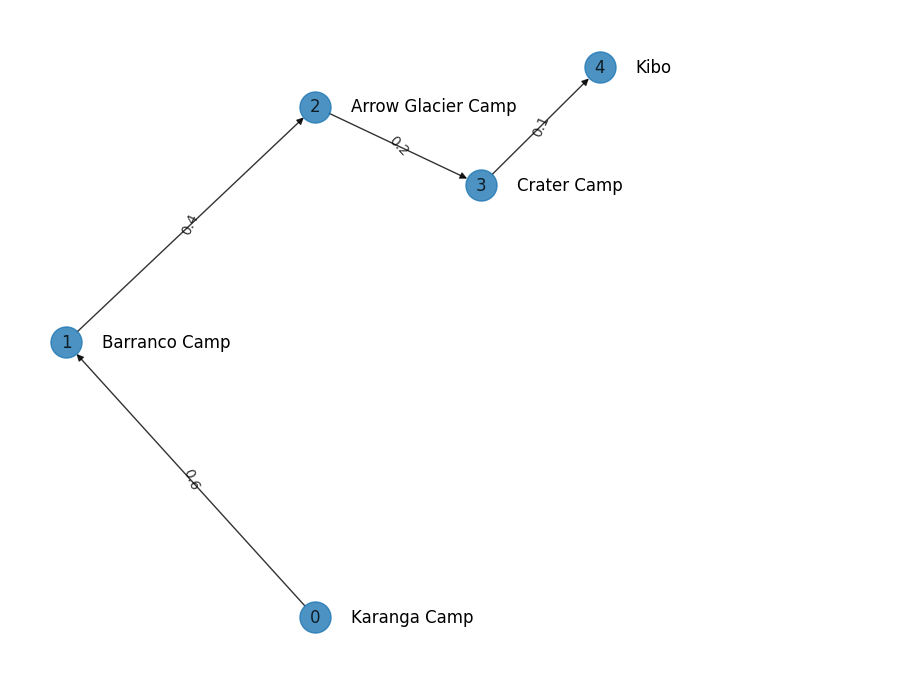

In [28]:
T = 100
adiabatic_quantum_state_2 = adiabatic_model_2.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec_2 = (np.abs(adiabatic_quantum_state_2) ** 2).argmax()

adiabatic_solution_2 = "{0:0{bits}b}".format(solution_dec_2, bits=nqubits)

display_solution_2(graph = G2, state = adiabatic_solution_2) # adiabatic solution is a binary string containing the solution

And we get the right solution! To make shure that we don't get here just by chance, if we flip the sign of the tsp part of the hamiltonian, effectively working with negative weights throughout, we should obtain the path of highest cost if all the formulation has been done correctly

[Qibo 0.1.13|WARNING|2023-07-13 00:21:25]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


node 0 is in position 1
node 1 is in position 2 and node 3 is in position 2
node 2 is in position 4
node 4 is in position 5


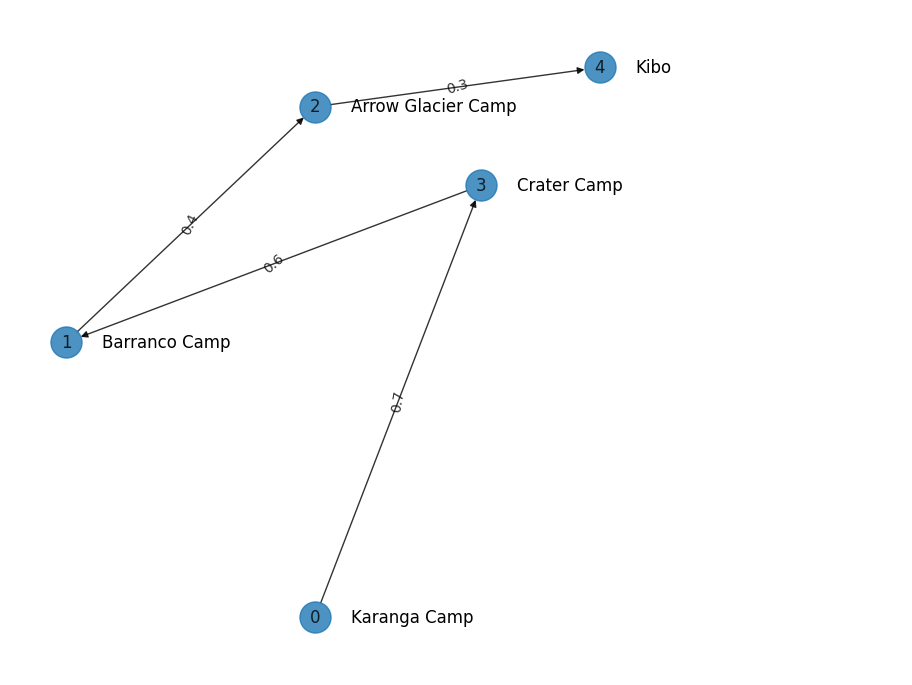

In [36]:
full_hamiltonian_3 = hamiltonians.SymbolicHamiltonian(-h_tsp_2+h_cycle_2)

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_3_dense = Hamiltonian(nqubits, full_hamiltonian_3.matrix)

# construct the adiabatic model
adiabatic_model_3 = AdiabaticEvolution(H0_2_dense, H1_3_dense, s, dt)

T = 100
adiabatic_quantum_state_3 = adiabatic_model_3.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec_3 = (np.abs(adiabatic_quantum_state_3) ** 2).argmax()

adiabatic_solution_3 = "{0:0{bits}b}".format(solution_dec_3, bits=nqubits)

display_solution_2(graph = G2, state = adiabatic_solution_3)

Which is indeed the path of maximum distance, therefore ensuring that our problem encoding makes sense and has as its hround state the problem's solution.

For the QAOA, we will follow the same steps as before but adjusting for the fact that we have 6 qubits instead of 9, and that we cannot construct the hamiltonians out of the graph directly.
Also, for the mixer, since now we are not working with all nodes being able to be in all positions, we cannot use the mixer structure given in [6]. Instead, we will use the very basic X mixer, given in page 5 of [4], which seems to works very well for this problem.

In [52]:
nqubits = 6
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian_2 = hamiltonians.SymbolicHamiltonian(h_cycle_2+h_tsp_2)

# create the mixer Hamiltonian for the given graph
mixer = 0
for i in range(6):
    for j in range(i):
        if i != j:
            mixer += s_minus(i)*s_minus(j)*s_plus(i)*s_plus(j)
mixer_hamiltonian_2 = hamiltonians.SymbolicHamiltonian(mixer)

# mixer_hamiltonian_2 = hamiltonians.SymbolicHamiltonian(sum(X(i) for i in range(6)))


# create QAOA model given the Hamiltonians
qaoa_2 = models.QAOA(hamiltonian=hamiltonian_2, mixer=mixer_hamiltonian_2)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 10
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state_2 = np.ones(2**nqubits)/(np.sqrt(2**nqubits))

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy_2, final_parameters_2, extra_2 = qaoa_2.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state_2)

print("best energy: ", best_energy_2)

number of qubits needed to solve the problem:  6
best energy:  6.049999999999978


node 0 is in position 1
node 1 is in position 2
node 3 is in position 2 and node 1 is in position 3
node 3 is in position 3
node 3 is in position 4
node 4 is in position 5


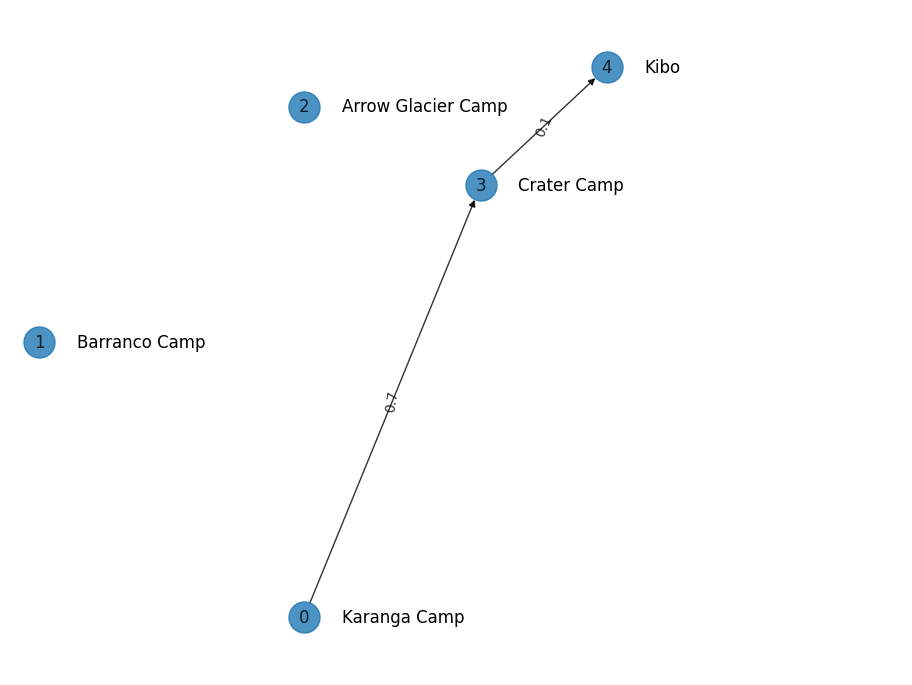

In [53]:
qaoa_2.set_parameters(final_parameters_2)
quantum_state_2 = qaoa_2.execute(initial_state_2)

# measure the output of the circuit and obtain results
nshots= 10000
circuit_2 = Circuit(nqubits)
circuit_2.add(gates.M(*range(nqubits)))
result_2 = CircuitResult(qaoa_2.backend, circuit_2, quantum_state_2, nshots=nshots)
freq_counter_2 = result_2.frequencies()

# order the results according to the frequencies
ordered_freq_counter_2 = sorted(freq_counter_2.items(), key=lambda item: item[1], reverse=True)
qaoa_solution_2 = ordered_freq_counter_2[0][0]

display_solution_2(graph = G2, state = qaoa_solution_2)

And again, we get the right solution, this time with even higher probability than in the 3 node fully connected case of the first part of the problem, even though the mixer is very simple.
All in all though, while the formulation of th hamiltonian is not very elegant, we have been able to encode all the constraints of the problem in just 6 qubits and obtain the right solution with both AQO and QAOA. More work could be done to try to get all the information that we have encoded in the hamiltonian from the gaph directly, but this is a good first approach, that at the end of the day, encodes the right information and allows us to solve the problem.